<a href="https://colab.research.google.com/github/TatianaShavrina/presentations/blob/master/NLP_intro_Fake_news_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Классификация новостей: настоящие или фейк-ньюз?

Давайте посмотрим, сможет ли алгоритм отличить настоящие новости от фейков.

Для этого мы будем загружать уже размеченные данные из [репозитория](https://github.com/TatianaShavrina/presentations), изучим их состав и проверим, что же получается у машины.

## Шаг 1 - импортируем код, который понадобится

In [17]:
import pandas as pd
from sklearn.utils import shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['text', 'shuffle', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Шаг 2 - загрузка данных

In [18]:
url = 'https://raw.githubusercontent.com/TatianaShavrina/presentations/master/CDTO/gold.csv'

data = pd.read_csv(url, sep='\t')

## Шаг 3 - анализ данных

Что в данных, которые мы загружаем? Посмотрим на первые 5 строк таблицы

In [19]:
data.head()

,text,class
0,Британское министерство информации приняло дек...,fake
1,"Альбом ""Chief"" кантри-исполнителя Эрика Черча ...",true
2,Новый вид микрокредитных организаций появился ...,fake
3,Один из крупнейших торговых комплексов Москвы ...,fake
4,Министерство обороны Белоруссии приостановила ...,true


Видим, что у нас есть колонка class - посмотрим, какие классы размечены, и сколько примеров каждого класса в таблице:

In [20]:
data['class'].value_counts()

true    4974
fake    1050
Name: class, dtype: int64

Всего фейков 1050 штуки - немного! Хотелось бы на какой-нибудь посмотреть:


In [21]:
print(data[data['class']=='fake'].iloc[2].to_dict())

{'text': 'Один из крупнейших торговых комплексов Москвы Садовод будет включён в список культурного наследия ЮНЕСКО. К такому выводу пришла комиссия ООН по вопросам образования науки и культуры после инспекции самого большого оптового рынка России.\nНесмотря на неидеальную чистоту следует отметить необычайный мультикультурализм заложенный здесь на протяжении десятилетий. Все континенты сливаются в один а народы общаются друг с другом как братья. При этом нет никаких этнических расовых и религиозных конфликтов. Надеюсь в будущем такие центры появятся в Берлине Париже Лондоне и других мировых мегаполисах  поделилась впечатлениями от посещения рынка инспектор ООН Жаннет Лаврин.\nАдминистрация Садовода с воодушевлением восприняла радостную для себя новость и в связи с обретением почётного статуса объявила шашлычную неделю в рамках которой хозяева обещают побаловать покупателей шашлыка щедрыми скидками. Мэрия Москвы уже объявила конкурс на создание памятной таблички с логотипом ЮНЕСКО.\n', '

Еще пример:

In [22]:
print(data[data['class']=='fake'].iloc[5].to_dict())

{'text': 'Губернатор Хакасии Валентин Коновалов объявил о новом формате празднования Нового года в республике. По мнению главы региона праздник необходимо встретить в коммунистическом формате а 1 января сделать днём старта новой пятилетки.\nДля поддержания праздничной атмосферы на центральной площади Абакана пройдут костюмированные шествия пролетариата с демонстрацией коммунистической символики  серпа и молота. Деды Морозы облачатся в одеяния с символикой КПРФ и будут дарить детям пионерские галстуки значки юного октябрёнка а также агитационные материалы. Родители за символическую сумму в 100 рублей смогут получить корочку члена Компартии.\nУвлекательной будет и творческая программа. Гостей площади Ленина ожидают лучшие выступления партийных деятелей Компартии также из динамиков прозвучат популярные советские песни в исполнении Клавдии Шульженко Лидии Руслановой Иосифа Кобзона и множества знаменитых советских артистов.\nЗавершит празднование новогоднее поздравление Иосифа Сталина после

Чтобы обучить алгоритм различать фейки и реальные новости, заранее подготовим наши примеры: отделим 10% всех данных, чтобы машина их не увидела, и оставим их для тестирования.

Будем использовать переменные X и y, где  X - это тексты, а y - это класс.

In [24]:
y = data["class"]
X = data["text"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

## Шаг 4 - обучение

в качестве самого простого классификатора возьмем Логистическую регрессию
Ей будут подаваться тексты в списка слов, и у каждого слова можель найдет его вес важности для класса. На основании всех слов текста модель будет решать, является ли новость настоящей.

In [25]:
def tokenizer(text):
    text = re.sub('\n', '', text)
    text = re.sub('\t', '', text)
    text = re.sub('\s', ' ', text)
    text = re.sub('[\.\,\-\!\?;:\(\)]', '', text)
    return text.lower().split()

In [26]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3), analyzer='word', max_features=200, tokenizer=tokenizer)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', LogisticRegression(random_state=42)   ),
    ])

In [27]:
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

Точность классификации:   0.95
Полнота:   0.91
F1-мера:   0.93
Всего % правильных ответов:   0.96
              precision    recall  f1-score   support

        fake       0.94      0.83      0.88       103
        true       0.96      0.99      0.98       500

    accuracy                           0.96       603
   macro avg       0.95      0.91      0.93       603
weighted avg       0.96      0.96      0.96       603



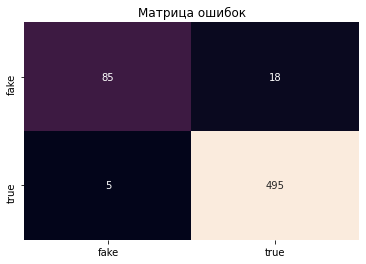

In [28]:
print("Точность классификации: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Полнота: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-мера: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Всего % правильных ответов: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Матрица ошибок")
plt.show()

## Шаг 5 - анализ результатов

Выше мы видим метрики, полученные в результате обучения.
Кажется, они достаточно неплохие. Давайте проверим на практике:
выведем пример и заставим модель предстазать его класс.

In [29]:
text = '''Крымские виноделы прекратят использование аммиачной селитры для производства продукции

Крымский производитель вин «Массандра» получит дотацию в 15 миллионов рублей из государственного бюджета для отказа от использования в будущем аммиачной селитры на производстве.
Ежегодно около 5 тысяч тонн аммиачной селитры используются как удобрение для виноградников, около 500 килограмм – в производстве пробок для шампанского. Взрыв на складе в Бейруте вынудил &quot;Массандру&quot; задуматься о мерах безопасности, что поставило компанию в трудное положение.
«В новых условиях сохранить наше производство и качество продукта без повышения цены было бы невозможно. Виноград может расти и сам, но и человеческий ресурс вместе с ним неумолимо растёт. Да и пробка из бутылки шампанского сама по себе не вылетит, нужно придумывать новые методы и технологии», — заявил директор отдела маркетинга «Массандры» Ицхак Рубенштейн.'''
clf.predict([text])[0]

'true'

In [30]:
text = '''Сервис «Яндекса» Алиса заменит часть педагогов в новом учебном году
Министерство просвещения приняло новую программу оптимизации кадров в учебных заведениях. Поскольку в новом учебном году запланировано значительное уменьшение количества часов в школах пройдут массовые сокращения. Чтобы последствия этого процесса не отразились на качестве образования в ведомстве предложили заменить уволенных учителей отечественным голосовым помощником «Яндекс. Алиса».'''
clf.predict([text])[0]

'true'

В примере ниже можно поменять текст на любой другой и проверить - сможет ли его корректно обработать модель?

In [31]:
text = '''пример текста'''
clf.predict([text])[0]

'true'

## Шаг 6 - посмотрим самые важные признаки

In [32]:
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20):
  coef = classifier.coef_.ravel()
  top_positive_coefficients = np.argsort(coef)[-top_features:]
  top_negative_coefficients = np.argsort(coef)[:top_features]
  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  # create plot
  plt.figure(figsize=(25, 10))
  colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)
  print(feature_names[top_coefficients])
  plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
  plt.show()

['и' 'мы' 'я' 'сказал' 'во время' 'будет' '1' 'но' 'в' 'уже' 'лет' 'на'
 'не' 'страны' 'бы' 'из' 'будут' 'по словам' 'территории' 'у' 'около'
 'июня' 'сентября' 'февраля' 'отметил' 'октября' 'сообщалось' 'декабря'
 '2011' 'июля' 'процентов' 'апреля' 'еще' 'об этом' 'риа' 'пишет' 'ноября'
 'ее' '—' 'сообщает']


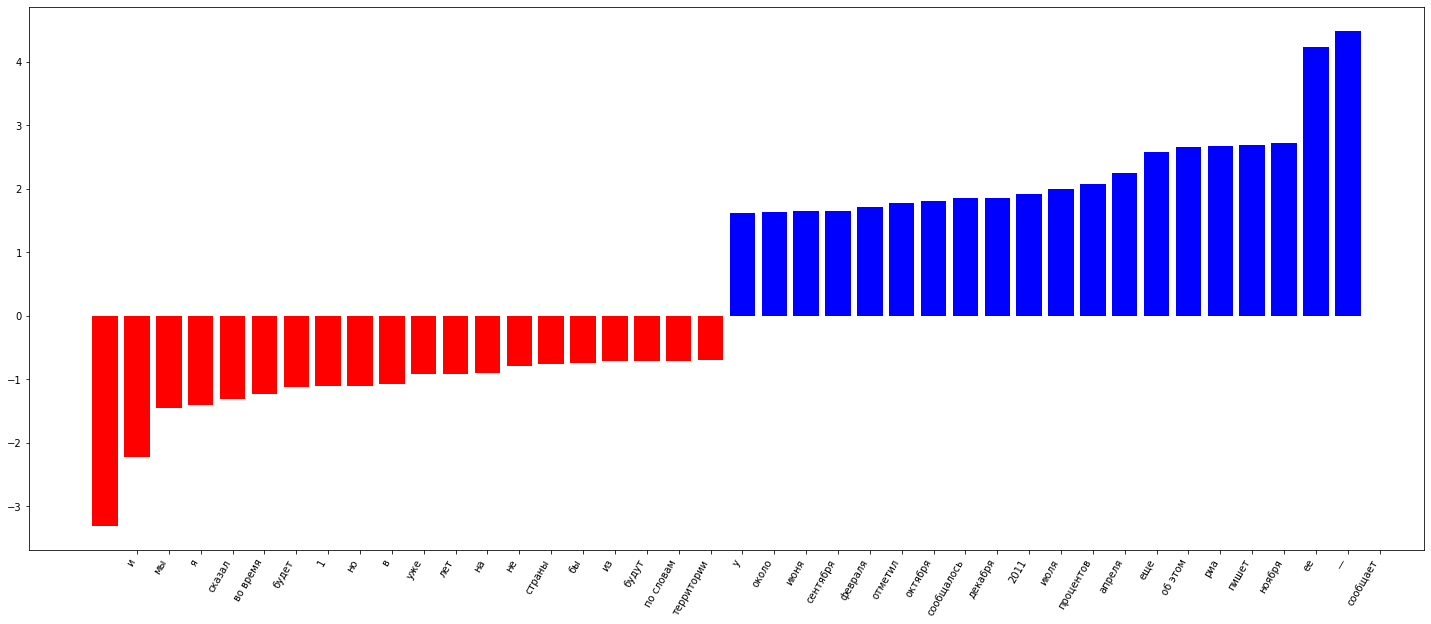

In [33]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,3), analyzer='word', max_features=200, tokenizer=tokenizer)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', LinearSVC( random_state=42)   ),
    ])
clf.fit(X_train, y_train)
plot_coefficients(clf['clf'], clf['vect'].get_feature_names() )

In [35]:
clf.predict(['''Я заметил, что многие «настоящие» американцы, которых они узнают по публичной деятельности, или те, с которыми имеют дело, которые относятся к «обычным» гражданам США и т.д. ужасно кривят лицом. И вот они чувствуют, что что-то не так, что-то не так, они интуитивно понимают, что что-то не так (и начинают думать, «что», в общем-то, подсознательно). И «в свете последних событий» они начинают приводить в пример настоящий «большинства» граждан США.'''])[0]

'fake'

In [36]:
clf.predict(['''В России две беды - дураки и дороги.
Эту новость на днях разместил в своем инстаграме редактор издания The New Yorker Дэвид Фрэзер. В статье подробно рассказывается о России, которая является лидером по количеству аварий в мире, и главными причинами которых становятся неисправные дороги, а также об особых проблемах с точки зрения перевозок через страну.

Фрэзер объясняет, что Москва и ее жители привыкли воспринимать свою столицу как средоточие благополучия и процветания. Эта причина является одной из главных проблем, с которой он столкнулся, когда был репортером в 2017 году. Он заявил, что русские убеждены в том, что страна находится в центре величайшего в мире богатства, однако это не так.

"Я был в Москве как гость и журналист в последние несколько месяцев. Это ад", - заявил Фрэзер. По его словам, россияне, проживающие в других регионах страны, не имеют такого же представления о Москве как он.

Он также отметил, что путешественники, которые не были в столице, не смогут это почувствовать. "Россияне хотят видеть дворец Путина, и если он находится в Подмосковье, он не сильно отличается от того, что находится в Чечне. Просто, в отличие от Чечни, он выглядит иначе", - объяснил журналист.

Также он добавил, что не смог распознать масштабы коррупции в России. "Я не встречал ни одного российского чиновника, который был бы бедным. Однако я не смог обнаружить, чтобы кто-то сидел за коррупцию", - сказал Фрэзер.
'''])[0]

'true'